# Approximate State Preparation via Sweeping

Tensor networks are a natural way to interact with quantum circuits and develop algorithms for them. A major application of tensor networks is in performing circuit optimization,
either via MPS/MPO IRs, or via sweeping. We focus on using tensor network sweeping as an algorithm to optimize arbitrary ansatzes to approximate a target statevector or unitary
in a smooth, consistently improving manner. The approach is a much better alternative for such cases compared to gradient-based and ML approaches which are prone to local minimas
and barren plateaus. For a better understanding of the technique see [1].

In this notebook, we evaluate the performance of the sweeping algorithm for approximate state preparation, and compare its depth to exact preparation algorithms.


---
# References <a name="ref"></a>

[1] M. S. Rudolph, J. Chen, J. Miller, A. Acharya, A. Perdomo-Ortiz (2022). \"Decomposition of Matrix Product States into Shallow Quantum Circuits\", [arXiv:2209.00595](https://arxiv.org/abs/2209.00595)."

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from braket.devices import LocalSimulator
from braket.experimental.algorithms.sweeping import (
    generate_staircase_ansatz,
    sweep_state_approximation,
)

In [2]:
def compile_with_state_sweep_pass(num_qubits: int) -> tuple[float, int]:
    state = np.random.uniform(-1, 1, 2**num_qubits) + 1j * np.random.uniform(-1, 1, 2**num_qubits)
    state /= np.linalg.norm(state)

    compiled_circuit = sweep_state_approximation(
        target_state=state,
        unitary_layers=generate_staircase_ansatz(
            num_qubits=num_qubits, num_layers=int((num_qubits**2) / 2)
        ),
        num_sweeps=100 * num_qubits,
        log=False,
    )

    result = LocalSimulator("braket_sv").run(compiled_circuit.state_vector(), shots=0).result()
    fidelity = np.abs(np.vdot(state, result.values[0]))

    return fidelity, compiled_circuit.depth

# Run on a local simulator
We run the compiled circuit on a classical simulator first. You can choose between a local simulator or an on-demand simulator.

In [3]:
fidelities = []
depths = []

for num_qubits in range(2, 10):
    fidelity, depth = compile_with_state_sweep_pass(num_qubits)
    fidelities.append(fidelity)
    depths.append(depth)

100%|██████████| 900/900 [02:16<00:00,  6.60it/s]


In [12]:
print(f"Average Fidelity: {np.mean(fidelities):.4f}")

Average Fidelity: 1.0000


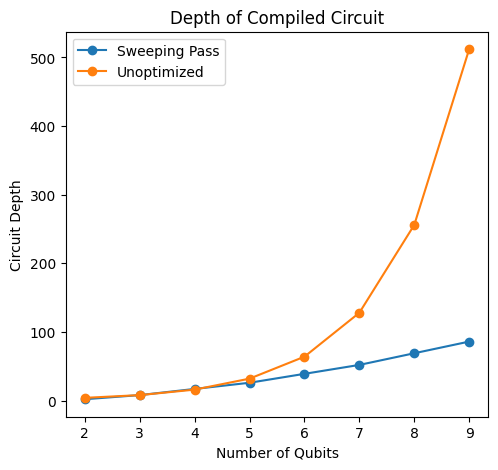

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, 10), depths, marker="o", label="Sweeping Pass")
plt.plot(range(2, 10), [2**n for n in range(2, 10)], marker="o", label="Exact")
plt.title("Depth of Compiled Circuit")
plt.xlabel("Number of Qubits")
plt.ylabel("Circuit Depth")
plt.legend()

Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).